In [ ]:
%load_ext autoreload
%autoreload 2
%matplotlib widget

In [ ]:
import sys
import pandas as pd

sys.path.append('../../../param_search')
import param_search as ps

ps.set_verbose(False)
ps.set_backend('slurm')

In [ ]:
csv_path = '2025-11-02_selected.csv'
sel = pd.read_csv(csv_path)
sel

In [ ]:
base_dir = '2025-11-02_preprocess'

template = '''\
#!/bin/bash -l
#SBATCH --job-name={job_name}
#SBATCH --account=asc170022p
#SBATCH --partition=GPU-shared
#SBATCH --gres=gpu:1
#SBATCH -t 24:00:00
set -eo pipefail

LP=$PROJECT/lung-project
NB=$PROJECT/lung-project/notebooks/shapenet

mamba activate /ocean/projects/asc170022p/mtragoza/mambaforge/envs/warp

python $LP/preprocess.py --dataset shapenet --data_root $LP/data/ShapeNetSem --variant {variant} --config $NB/{config} --subject {subject}

'''
name_format = '{params_hash}'

grid = ps.param_grid(subject=sel.subject, variant='2025-11-02', config='2025-11-02_config.json')
len(grid)

In [ ]:
# changes:
# - image generation with solid texture networks (same variant)
# - use cell label as source of truth, map cell date to node data
# - use P0 scalar material fields in forward FEM simulation (need P1 in inverse for TV reg gradient)
# - reduce material vote rate 1e-3 to 1e-4 for more variation

base_dir = '2025-11-05_preprocess'

template = '''\
#!/bin/bash -l
#SBATCH --job-name={job_name}
#SBATCH --account=asc170022p
#SBATCH --partition=GPU-shared
#SBATCH --gres=gpu:1
#SBATCH -t 24:00:00
set -eo pipefail

LP=$PROJECT/lung-project
NB=$PROJECT/lung-project/notebooks/shapenet

mamba activate /ocean/projects/asc170022p/mtragoza/mambaforge/envs/warp

python $LP/preprocess.py --dataset shapenet --data_root $LP/data/ShapeNetSem --variant {variant} --config {config} --subject {subject}

'''
name_format = '{params_hash}'

grid = ps.param_grid(subject=sel.subject, variant='2025-11-02', config='2025-11-05_config.json')
len(grid)

In [ ]:
# changes:
# - post-CVPR pipeline refactoring + YAML config + overrides
# - simplified material catalog (5 E levels, no rho variation)

base_dir = '2025-11-20_preprocess'

template = '''\
#!/bin/bash -l
#SBATCH --job-name={job_name}
#SBATCH --account=asc170022p
#SBATCH --partition=GPU-shared
#SBATCH --gres=gpu:1
#SBATCH -t 24:00:00
set -eo pipefail

LP=$PROJECT/lung-project
NB=$PROJECT/lung-project/notebooks/shapenet

mamba activate /ocean/projects/asc170022p/mtragoza/mambaforge/envs/warp

python $LP/preprocess.py {config} --set dataset.examples.subjects={subject}

'''
name_format = '{params_hash}'

grid = ps.param_grid(subject=sel.subject, variant='2025-11-20', config='2025-11-20_config.yaml')
len(grid)

In [ ]:
# changes:
# - different seed per subject for texture variation

base_dir = '2025-12-21_preprocess'

template = '''\
#!/bin/bash -l
#SBATCH --job-name={job_name}
#SBATCH --account=asc170022p
#SBATCH --partition=GPU-shared
#SBATCH --gres=gpu:1
#SBATCH -t 24:00:00
set -eo pipefail

LP=$PROJECT/lung-project
NB=$PROJECT/lung-project/notebooks/shapenet

mamba activate /ocean/projects/asc170022p/mtragoza/mambaforge/envs/warp

python $LP/preprocess.py {config} --set dataset.examples.subjects={subject}

'''
name_format = '{params_hash}'

grid = ps.param_grid(subject=sel.subject, variant='2025-11-20', config='2025-11-20_config.yaml')
len(grid)

In [ ]:
# changes:
# - new config file (date typo fixed- its now 2026)
# - new materials catalog (uniform prior, density = 1000, uniform texture range = 1.0)

base_dir = '2026-01-15_preprocess'

template = '''\
#!/bin/bash -l
#SBATCH --job-name={job_name}
#SBATCH --account=asc170022p
#SBATCH --partition=GPU-shared
#SBATCH --gres=gpu:1
#SBATCH -t 24:00:00
set -eo pipefail

LP=$PROJECT/lung-project
NB=$PROJECT/lung-project/notebooks/shapenet

mamba activate /ocean/projects/asc170022p/mtragoza/mambaforge/envs/warp

python $LP/preprocess.py {config} --set dataset.examples.subjects={subject}

'''
name_format = '{params_hash}'

grid = ps.param_grid(subject=sel.subject, config='2026-01-15_config.yaml')
len(grid)

In [ ]:
%autoreload
try:
    jobs = ps.setup(base_dir, template, name_format, grid, overwrite=False)
except OSError:
    jobs = ps.load(base_dir)

jobs

In [10]:
%autoreload
jobs = ps.recover(jobs)
jobs = ps.status(jobs)
jobs = ps.history(jobs)
jobs.groupby(['job_state']).count()

,job_name,n_submits,job_id,node_id,runtime,stdout,stderr,base_dir,work_dir,script_path,...,params.subject,params.config,output_exists,output_fsize,output_mtime,array_idx,last_live_at,state_source,finalized,finalized_at
job_state,,,,,,,,,,,,,,,,,,,,,
COMPLETED,1116,1116,1116,1116,1116,131,131,1116,1116,1116,...,1116,1116,1116,0,0,0,994,1116,1116,1116


In [11]:
jobs = ps.collect(jobs)

In [12]:
jobs[jobs.job_state == 'FAILED'].iloc[0]

IndexError: single positional indexer is out-of-bounds

In [ ]:
print(jobs[jobs.job_state == 'FAILED'].iloc[0].stderr)

In [32]:
# mark jobs to resubmit
#jobs.loc[(jobs.job_state == 'FAILED'), 'job_id'] = pd.NA
jobs.loc[:, 'job_id'] = pd.NA

In [40]:
%autoreload
jobs = ps.submit(jobs)

In [25]:
sys.path.append('../..')
import project
config = project.core.fileio.load_config('2026-01-15_config.yaml')
config['dataset']['examples']['subjects'] = csv_path
config

Loading 2026-01-15_config.yaml


{'dataset': {'name': 'ShapeNet',
  'root': '/ocean/projects/asc170022p/mtragoza/lung-project/data/ShapeNetSem',
  'examples': {'subjects': '2025-11-02_selected.csv', 'variant': '2026-01-15'},
  'metadata': {'parse_metadata': True,
   'unit_policy': 'prefer_metadata',
   'default_unit': 0.01},
  'selectors': {}},
 'preprocessing': {'binary_mask': {'foreground_filter': {'max_components': 1,
    'keep_largest': True},
   'background_filter': {'min_voxels': 30},
   'center_mask': True,
   'pad_amount': 0.37},
  'surface_mesh': {'run_pymeshfix': True},
  'region_mask': {'label_method': 'nearby_faces',
   'region_filter': {'min_voxels': 1000, 'keep_largest': False}},
  'volume_mesh': {'use_affine_spacing': False,
   'meshing_parameters': {'max_facet_distance': 0.75,
    'max_cell_circumradius': 5.0,
    'lloyd': True,
    'odt': True}},
  'material_mask': {'material_catalog': '/ocean/projects/asc170022p/mtragoza/lung-project/notebooks/shapenet/2026-01-15_materials.csv',
   'material_sampling

In [26]:
examples = project.api.get_examples(config['dataset'])
examples

Gathering examples


[Example(dataset='ShapeNet', subject='wss.100f39dce7690f59efb94709f30ce0d2', variant='2026-01-15', paths={'source_mesh': PosixPath('/ocean/projects/asc170022p/mtragoza/lung-project/data/ShapeNetSem/models-OBJ/models/100f39dce7690f59efb94709f30ce0d2.obj'), 'source_mask': PosixPath('/ocean/projects/asc170022p/mtragoza/lung-project/data/ShapeNetSem/models-binvox-solid/100f39dce7690f59efb94709f30ce0d2.binvox'), 'binary_mask': PosixPath('/ocean/projects/asc170022p/mtragoza/lung-project/data/ShapeNetSem/2026-01-15/100f39dce7690f59efb94709f30ce0d2/masks/mask.nii.gz'), 'region_mask': PosixPath('/ocean/projects/asc170022p/mtragoza/lung-project/data/ShapeNetSem/2026-01-15/100f39dce7690f59efb94709f30ce0d2/masks/mask_regions.nii.gz'), 'material_mask': PosixPath('/ocean/projects/asc170022p/mtragoza/lung-project/data/ShapeNetSem/2026-01-15/100f39dce7690f59efb94709f30ce0d2/masks/mask_regions_material.nii.gz'), 'surface_mesh': PosixPath('/ocean/projects/asc170022p/mtragoza/lung-project/data/ShapeNetSe

In [28]:
ex = examples[0]
ex

Example(dataset='ShapeNet', subject='wss.100f39dce7690f59efb94709f30ce0d2', variant='2026-01-15', paths={'source_mesh': PosixPath('/ocean/projects/asc170022p/mtragoza/lung-project/data/ShapeNetSem/models-OBJ/models/100f39dce7690f59efb94709f30ce0d2.obj'), 'source_mask': PosixPath('/ocean/projects/asc170022p/mtragoza/lung-project/data/ShapeNetSem/models-binvox-solid/100f39dce7690f59efb94709f30ce0d2.binvox'), 'binary_mask': PosixPath('/ocean/projects/asc170022p/mtragoza/lung-project/data/ShapeNetSem/2026-01-15/100f39dce7690f59efb94709f30ce0d2/masks/mask.nii.gz'), 'region_mask': PosixPath('/ocean/projects/asc170022p/mtragoza/lung-project/data/ShapeNetSem/2026-01-15/100f39dce7690f59efb94709f30ce0d2/masks/mask_regions.nii.gz'), 'material_mask': PosixPath('/ocean/projects/asc170022p/mtragoza/lung-project/data/ShapeNetSem/2026-01-15/100f39dce7690f59efb94709f30ce0d2/masks/mask_regions_material.nii.gz'), 'surface_mesh': PosixPath('/ocean/projects/asc170022p/mtragoza/lung-project/data/ShapeNetSem

Loading /ocean/projects/asc170022p/mtragoza/lung-project/data/ShapeNetSem/2026-01-15/100f39dce7690f59efb94709f30ce0d2/images/mask_regions_material_image.nii.gz
Loading /ocean/projects/asc170022p/mtragoza/lung-project/data/ShapeNetSem/2026-01-15/100f39dce7690f59efb94709f30ce0d2/fields/mask_regions_material_density.nii.gz
Loading /ocean/projects/asc170022p/mtragoza/lung-project/data/ShapeNetSem/2026-01-15/100f39dce7690f59efb94709f30ce0d2/fields/mask_regions_material_elastic.nii.gz
(-0.05464591085910797, 1.769261360168457)


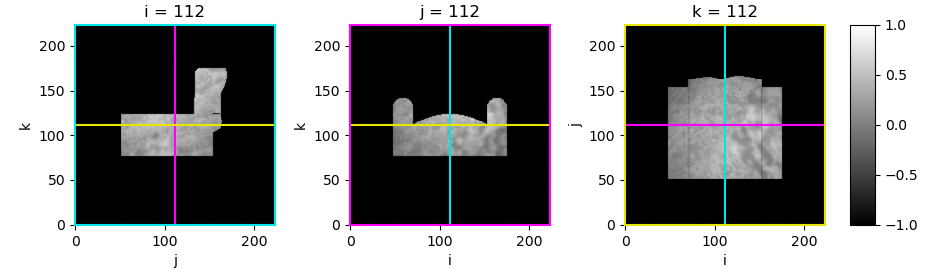

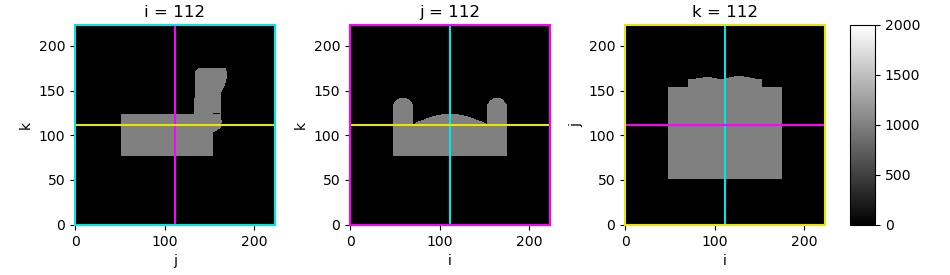

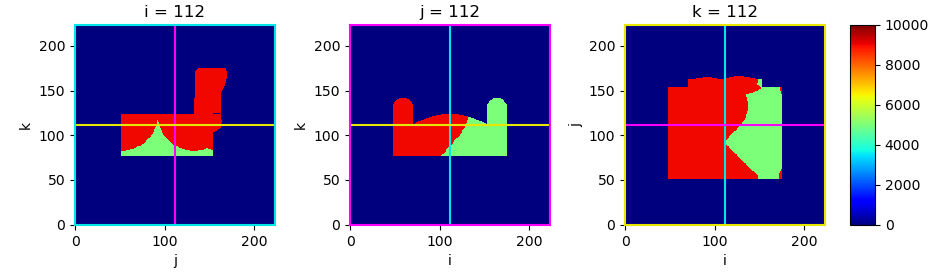

In [32]:
%matplotlib widget
import project.visual.matplotlib

image = project.core.fileio.load_nibabel(ex.paths['input_image']).get_fdata()
density = project.core.fileio.load_nibabel(ex.paths['density_field']).get_fdata()
elastic = project.core.fileio.load_nibabel(ex.paths['elastic_field']).get_fdata()

clim = (float(image.min()), float(image.max()))
print(clim)

_ = project.visual.matplotlib.show_image_slices(image - 1.0, cmap='gray', clim=(-1, 1), colors='cmy')
_ = project.visual.matplotlib.show_image_slices(density, cmap='gray', clim=(0, 2000), colors='cmy')
_ = project.visual.matplotlib.show_image_slices(elastic, cmap='jet',  clim=(0, 10000), colors='cmy')

array([0.   , 0.005, 0.02 , 0.045, 0.08 , 0.125, 0.18 , 0.245, 0.32 ,
       0.405, 0.5  , 0.595, 0.68 , 0.755, 0.82 , 0.875, 0.92 , 0.955,
       0.98 , 0.995, 1.   ])

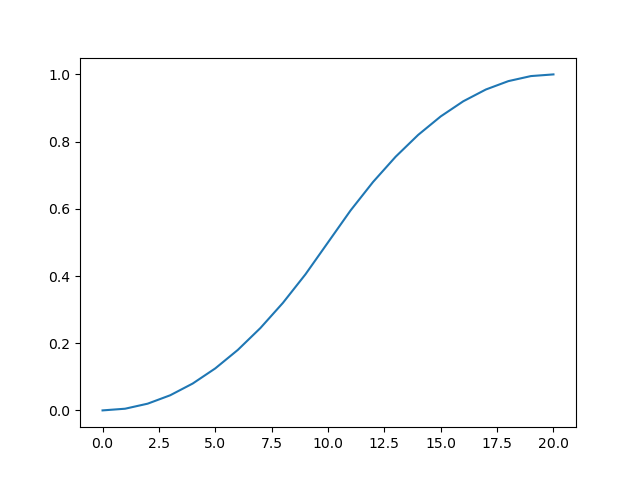

In [97]:
import matplotlib.pyplot as plt
import numpy as np
fig, ax = plt.subplots()

n = 11
x = np.arange(n)**2
x = (x + x.min()) / (x.max() - x.min()) / 2
x = np.concatenate([x, 1 - x[::-1][1::]])
ax.plot(x)
x

In [98]:
import project.visual.pyvista
image = project.core.fileio.load_nibabel(ex.paths['input_image']).get_fdata()
p = project.visual.pyvista.plot_volume(image, cmap='binary', clim=(0, 1), opacity=x)
p.show(jupyter_backend='trame')

Loading ../../data/ShapeNetSem/2025-11-02/13b48456dad49f8762edbb9e1af21a03/images/solid_texture.nii.gz


Widget(value='<iframe id="pyvista-jupyter_trame__template_P_0x14b6d36ef190_12" src="https://ondemand.bridges2.…